In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from pylab import rcParams
import re
import os
import time
from datetime import datetime

In [84]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4

In [85]:
df = pd.read_csv("readings.csv")
display(df.head())

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
0,1.500013,0.7200,3019.0,5.1,0.577148,46.6
1,2.400024,0.8806,3020.0,23.3,0.577148,46.6
2,2.400020,0.8806,3021.0,1.9,0.577148,47.2
3,2.400020,0.8806,3020.0,1.9,0.577148,47.2
4,2.400030,0.8806,3021.0,1.0,0.577148,46.6


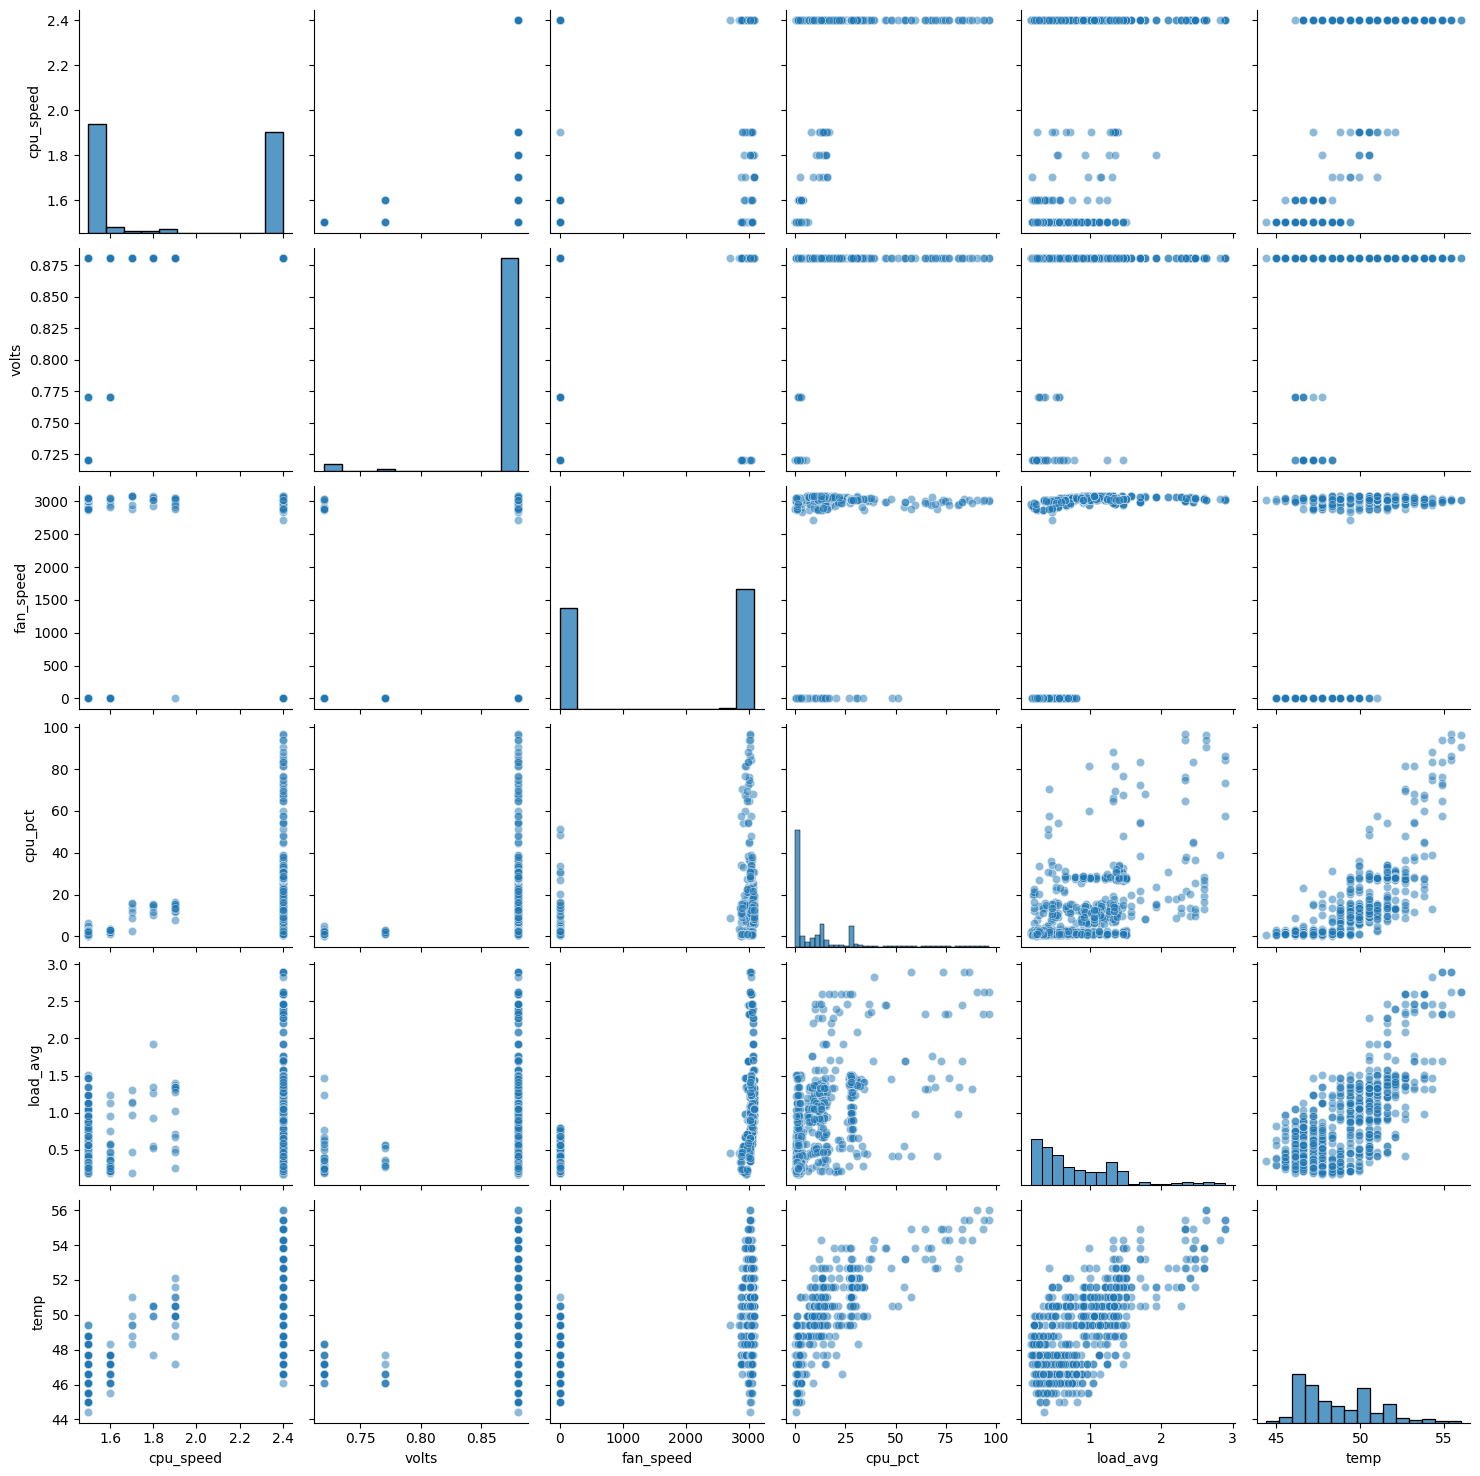

In [87]:
sns.pairplot(df.sample(1000), plot_kws=dict(alpha=0.5))

In [12]:
display(df.corr())

# We can strengthen our correlation by applying a rolling average to certain columns.
df_adjusted = df.copy()
rolling_cols = ['cpu_speed', 'volts', 'fan_speed', 'cpu_pct']
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()
display(df_adjusted.info())
display(df_adjusted.corr())

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
cpu_speed,1.000000,0.177681,0.702697,0.606381,0.587484,0.801637
volts,0.177681,1.000000,0.045159,0.112846,0.131240,0.133572
fan_speed,0.702697,0.045159,1.000000,0.480698,0.650322,0.648469
cpu_pct,0.606381,0.112846,0.480698,1.000000,0.599708,0.809144
load_avg,0.587484,0.131240,0.650322,0.599708,1.000000,0.766714
temp,0.801637,0.133572,0.648469,0.809144,0.766714,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cpu_speed  2496 non-null   float64
 1   volts      2496 non-null   float64
 2   fan_speed  2496 non-null   float64
 3   cpu_pct    2496 non-null   float64
 4   load_avg   2500 non-null   float64
 5   temp       2500 non-null   float64
dtypes: float64(6)
memory usage: 117.3 KB


None

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
cpu_speed,1.000000,0.266795,0.727922,0.650388,0.614881,0.824529
volts,0.266795,1.000000,0.073997,0.178357,0.201503,0.205284
fan_speed,0.727922,0.073997,1.000000,0.506010,0.655393,0.645568
cpu_pct,0.650388,0.178357,0.506010,1.000000,0.644502,0.836964
load_avg,0.614881,0.201503,0.655393,0.644502,1.000000,0.766714
temp,0.824529,0.205284,0.645568,0.836964,0.766714,1.000000


# Basic Linear Regression

In [88]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with one column, then with more than one. Comment out
# the one you don't want to use and uncomment the one you do.
# We know from the histograms that volts is probably useless as a predictor!
# feature_cols = ["load_avg"]
feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

'Train length: 1996, Test length: 500'

'Mean squared error: 0.68'

'Coefficient of determination: 0.87'

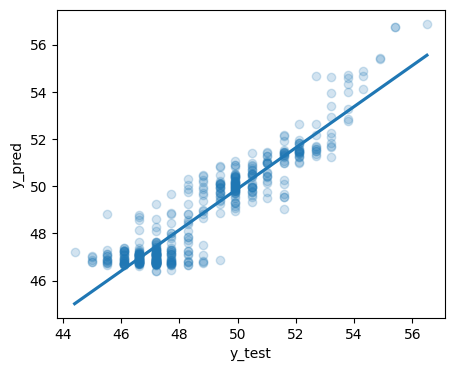

In [89]:
linreg = make_pipeline(StandardScaler(), 
                        LinearRegression()) 
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.2})
plt.xlabel('y_test')
plt.ylabel('y_pred')

display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

# Basic Logistic Regression

<Axes: >

'Train length: 1996, Test length: 500'

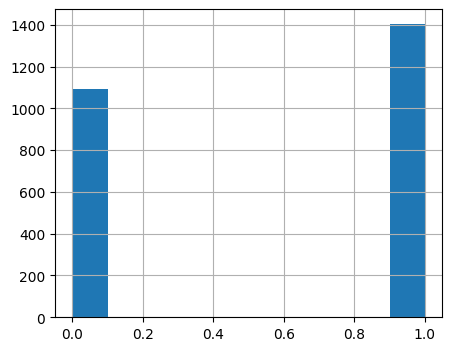

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.copy().dropna(how="any")

# Change fan speed into an on/off indicator.
df_data["fan_state"] = df_data.fan_speed.apply(lambda x: 1 if x > 0 else 0)
display(df_data.fan_state.hist())
feature_cols = ["volts", "cpu_pct", "load_avg", "cpu_speed", "temp"] # NOT fan speed!

X = df_data[feature_cols].values
y = df_data.fan_state.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

In [92]:
logreg = make_pipeline(StandardScaler(), 
                       LogisticRegression()) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       229
           1       0.94      0.89      0.91       271

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



array([[214,  15],
       [ 30, 241]])